# Install libraries

In [10]:
#installations
%pip install python-dotenv
%pip install langchain
%pip install langchain_ibm
%pip install langchain_core
%pip install langgraph
%pip install nasapy


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pi

# Imports

In [ ]:
#imports
from dotenv import load_dotenv
from os import environ
from nasapy import Nasa
from langchain_ibm import ChatWatsonx
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, END
from datetime import datetime, timedelta
from operator import add
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display

# Setup Credentials and Model Parameters 

In [ ]:
# load secrets
load_dotenv('../.env')

# credentials
credentials = {
    "url": environ.get("WATSONX_URL"),
    "apikey": environ.get("WATSONX_API_KEY"),
    "project_id": environ.get("PRJ_ID")
}
print(environ)
# params
params = {
    "decoding_method": "greedy",
    "temperature": 0, 
    "min_new_tokens": 5,
    "max_new_tokens": 250,
    "stop_sequences":['\n\n']
}

# model
llm = ChatWatsonx(
    model_id =  "meta-llama/llama-3-3-70b-instruct",
	url = credentials.get("url"),
	apikey = credentials.get("apikey"),
	project_id =  credentials.get("project_id"),
	params = params
)

environ({'COMMAND_MODE': 'unix2003', 'HOME': '/Users/paolo', 'JAVA_HOME': '/Users/paolo/OpenJDK/jdk-24.0.1.jdk/Contents/Home/bin', 'LOGNAME': 'paolo', 'MallocNanoZone': '0', 'OLDPWD': '/', 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined', 'PATH': '/usr/local/bin:/Users/paolo/Library/Python/3.12/bin:/Users/paolo/OpenJDK/jdk-24.0.1.jdk/Contents/Home/bin:/Library/Frameworks/Python.framework/Versions/3.13/bin:/opt/local/bin:/opt/local/sbin:/Library/Frameworks/Python.framework/Versions/3.12/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/TeX/texbin:/Users/paolo/OpenJDK/jdk-24.0.1.jdk/Contents/Home/bin:/Library/Frameworks/Python.framework/Versions/3.13/bin:/opt/local/bin:/opt/local/sbin:/Library/Frameworks/Python.framework/Versions/3.12/

# Test NASA API Key
Generate one on the [NASA website](https://api.nasa.gov)

In [13]:
# add your nasa api key
n = Nasa(key=environ.get("NASA_API_KEY"))
n.picture_of_the_day("2025-01-19")

{'date': '2025-01-19',
 'explanation': "What would it look like to land on Saturn's moon Titan? The European Space Agency's Huygens probe set down on the Solar System's cloudiest moon in 2005, and a time-lapse video of its descent images was created. Huygens separated from the robotic Cassini spacecraft soon after it achieved orbit around Saturn in late 2004 and began approaching Titan. For two hours after arriving, Huygens plummeted toward Titan's surface, recording at first only the shrouded moon's opaque atmosphere. The computerized truck-tire sized probe soon deployed a parachute to slow its descent, pierced the thick clouds, and began transmitting images of a strange surface far below never before seen in visible light. Landing in a dried sea and surviving for 90 minutes, Huygen's returned unique images of a strange plain of dark sandy soil strewn with smooth, bright, fist-sized rocks of ice.",
 'media_type': 'video',
 'service_version': 'v1',
 'title': 'Titan Touchdown: Huygens D

# Define Tools for the Agent

In [ ]:
# tools

@tool
def get_todays_date() -> str:
    """Get today's date in YYYY-MM-DD format.
    """
    date = datetime.now().strftime("%Y-%m-%d")
    return date

@tool
def get_yesterdays_date() -> str:
    """Get yesterday's date in YYYY-MM-DD format.
    """
    date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
    return date

@tool(return_direct=True)
def get_astronomy_image_for_today() -> str:
    """Get NASA's Astronomy Picture of the Day on today.
    """
    date = datetime.now().strftime("%Y-%m-%d")
    apod = n.picture_of_the_day(date, hd=True)
    return apod['url']

@tool(return_direct=True)
def get_astronomy_image_for_yesterday() -> str:
    """Get NASA's Astronomy Picture of the Day on yesterday.
    """
    date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
    apod = n.picture_of_the_day(date, hd=True)
    return apod['url']

@tool(return_direct=True)
def get_astronomy_image(date_of_picture: str) -> str:
    """Get NASA's Astronomy Picture of the Day on given date.
    
    Args:
        date_of_picture: the date for the picture of the day.
    """
    apod = n.picture_of_the_day(date_of_picture, hd=True)
    return apod['url']

tools = [get_todays_date, get_yesterdays_date, get_astronomy_image_for_today, get_astronomy_image_for_yesterday, get_astronomy_image]
tools_names = {t.name: t for t in tools}
llm_with_tools = llm.bind_tools(tools)

# Define the LangGraph agent

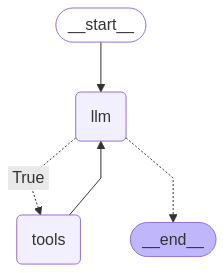

In [ ]:
# state class
class State(TypedDict):
  messages: Annotated[list[AnyMessage], add]

def execute_tools(state: State):
    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
      if not t['name'] in tools_names:
        result = "Error: There's no such tool, please try again"
      else:
        result = tools_names[t['name']].invoke(t['args'])
        results.append(
          ToolMessage(
            tool_call_id=t['id'],
            name=t['name'],
            content=str(result)
          )
        )
    return {'messages': results}

def tool_exists(state: State):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0
    
# func to add node
def run_llm(state: State):
    messages = state['messages']
    message = llm_with_tools.invoke(messages)
    return {'messages': [message]}

# create the agent graph
graph_builder=StateGraph(State)
graph_builder.add_node("llm", run_llm)
graph_builder.add_node("tools", execute_tools)
graph_builder.add_conditional_edges(
    "llm",
     tool_exists,
    {True: "tools", False: END}
    )

graph_builder.add_edge("tools", "llm")

graph_builder.set_entry_point("llm")

graph=graph_builder.compile()

# print the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Test the graph
messages = [HumanMessage(content="Tell me a joke about mathematics")]
result = graph.invoke({"messages": messages})
print(result)

{'messages': [HumanMessage(content='Tell me a joke about mathematics', additional_kwargs={}, response_metadata={}), AIMessage(content='I am not able to execute this task as it requires a function that is not available in the given list of functions.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 524, 'total_tokens': 549}, 'model_name': 'meta-llama/llama-3-3-70b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'}, id='chatcmpl-fc1087b071cd18666c3fd1c459e87d63', usage_metadata={'input_tokens': 524, 'output_tokens': 25, 'total_tokens': 549})]}


# Test Agent

In [ ]:
# handle printouts
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [ ]:
# test1
messages = [HumanMessage(content="What is today's date?")]
print_stream(graph.stream({"messages": messages}, stream_mode="values"))

================================ Human Message =================================

What is today's date?
================================== Ai Message ==================================
Tool Calls:
  get_todays_date (chatcmpl-tool-3a2c054d44aa41d9874b2eace448a146)
 Call ID: chatcmpl-tool-3a2c054d44aa41d9874b2eace448a146
  Args:
================================= Tool Message =================================
Name: get_todays_date

2025-04-28
================================== Ai Message ==================================

The current date is 2025-04-28.


In [ ]:
messages = [HumanMessage(content="What date was it 4 days ago?")]
print_stream(graph.stream({"messages": messages}, stream_mode="values"))

================================ Human Message =================================

What date was it 4 days ago?
================================== Ai Message ==================================
Tool Calls:
  get_astronomy_image (chatcmpl-tool-8c1a94e69079448490f87d44e9ce78b2)
 Call ID: chatcmpl-tool-8c1a94e69079448490f87d44e9ce78b2
  Args:
    date_of_picture: 2023-04-24
================================= Tool Message =================================
Name: get_astronomy_image

https://apod.nasa.gov/apod/image/2304/CTB1_Sibbald_960.jpg
================================== Ai Message ==================================

The date 4 days ago was April 24, 2023.


In [ ]:
messages = [HumanMessage(content="What is NASA's Astronomy Picture of the Day for today?")]
print_stream(graph.stream({"messages": messages}, stream_mode="values"))

================================ Human Message =================================

What is NASA's Astronomy Picture of the Day for today?
================================== Ai Message ==================================
Tool Calls:
  get_astronomy_image_for_today (chatcmpl-tool-78ef9e68b31841eb85d3ffed0cebb515)
 Call ID: chatcmpl-tool-78ef9e68b31841eb85d3ffed0cebb515
  Args:
================================= Tool Message =================================
Name: get_astronomy_image_for_today

https://apod.nasa.gov/apod/image/2504/Gum37Hoo_Bozon_960.jpg
================================== Ai Message ==================================

NASA's Astronomy Picture of the Day for today is https://apod.nasa.gov/apod/image/2504/Gum37Hoo_Bozon_960.jpg.


In [ ]:
messages = [HumanMessage(content="Show me NASA's Astronomy Picture using the date from 2 days ago.")]
print_stream(graph.stream({"messages": messages}, stream_mode="values"))

================================ Human Message =================================

Show me NASA's Astronomy Picture using the date from 2 days ago.
================================== Ai Message ==================================
Tool Calls:
  get_astronomy_image (chatcmpl-tool-c0f105ad3a3541259980863a9d9aac57)
 Call ID: chatcmpl-tool-c0f105ad3a3541259980863a9d9aac57
  Args:
    date_of_picture: 2022-08-15
================================= Tool Message =================================
Name: get_astronomy_image

https://apod.nasa.gov/apod/image/2208/CygnusWall_Bogaerts_960.jpg
================================== Ai Message ==================================

NASA's Astronomy Picture of the Day for 2 days ago is available at https://apod.nasa.gov/apod/image/2208/CygnusWall_Bogaerts_960.jpg.


In [ ]:
messages = [HumanMessage(content="Show me NASA's Astronomy Picture for one day ago.")]
print_stream(graph.stream({"messages": messages}, stream_mode="values"))

================================ Human Message =================================

Show me NASA's Astronomy Picture for one day ago.
================================== Ai Message ==================================
Tool Calls:
  get_astronomy_image_for_yesterday (chatcmpl-tool-e0723707a4aa4e728804427e779d32a3)
 Call ID: chatcmpl-tool-e0723707a4aa4e728804427e779d32a3
  Args:
================================= Tool Message =================================
Name: get_astronomy_image_for_yesterday

https://apod.nasa.gov/apod/image/2504/Spirograph_Hubble_960.jpg
================================== Ai Message ==================================

NASA's Astronomy Picture for one day ago can be found at https://apod.nasa.gov/apod/image/2504/Spirograph_Hubble_960.jpg.
